# HW 3 STA561

Griffin Riddler (0943004, gsr16), David Hunt (1169978, dmh89), Rucha Patil (1172230,rmp61), Angela Yoon (0966160, ay109), Shufan Xia (0766330, sx78)

In [74]:
import numpy as np
from sklearn import datasets,linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

## Black Box Tuning Class Declaration

While there were many ways to approach this problem, we opted to go with a class approach. Specifically, we created a BlackBoxTuner python class that would take in the necessary parameters and then perform the desired optimization using a .optimize() function. Additionally, we included useful functions to generate plots for the cross validation and an easy way to compute the average MSE and MAD accross all of the training data

### Declaring exceptions

To start out, we declare 2 exceptions to ensure that the user specifies a valid regularization method and CV metric. If the user does not provide a valid option, we specify default behavior so that the code would still work

In [75]:
class InvalidRegularizationException(Exception):
    """ Exception resulting from an invalid regularization method being specified"""

    def __init__(self, regularization_method):
        """ Initialize an InvalidRegularizationException

        Args:
            regularization_method (string): The specified regularization method
        """
        self.message = "{} not in ['Dropout','NoiseAddition','Robust']".format(regularization_method)
        super().__init__(self.message)

class InvalidMetricError(Exception):
    """ Exception resulting from an invalid regularization method being specified"""

    def __init__(self, metric):
        """ Initialize an InvalidRegularizationException

        Args:
            metric (string): The specified metric
        """
        self.message = "{} not in ['MSE','MAD']".format(metric)
        super().__init__(self.message)

### BlackBoxTuner Class

This is the main class for our optimization code. It includes all of the required variables and functions needed to perform regularization. The code is very modular allowing for new metrics or regularization methods to be easily added within the same framework. Additionally, we have one set of functions for CV (not one per regularization method) and several helpful plotting functions inorder to ensure that the code is working correctly

In [76]:

class BlackBoxTuner:
    def __init__(self,model,x,y,regularization_method="Dropout",M=10,c=[],k_folds=10,metric="MSE"):
        """initialize a new instance of the BlackBoxTuner Class

        Args:
            model (sklearn estimator): the model to be optimized
            x (np.array): NxP array with N samples (p features per sample). Data must be normalized and centered
            y (np.array): Nx1 array with the output for each input sample
            regularization_method (str, optional): Regularization method chosen from (Dropout','NoiseAddition','Robust'). Defaults to "Dropout".
            M (int, optional): number of Monte Carlo replicates used when regression method is 'Dropout' or 'NoiseAddition'. Defaults to 10.
            c (list, optional): Nx1 column vector used if method is 'Robust'. Defaults to [].
            k_folds (int, optional): number of folds to be used for cross validation and tuning (must be no larger than N-1). Defaults to 10.
            metric (str, optional): evaluation metric to be used when scoring chosen from ('MSE','MAD'). Defaults to "MSE".
        """
        #set standard parameters
        self.clf = model
        self.x_train = x
        self.y_train = y
        self.num_MonteCarlo = M
        self.robust_column_bounds = c
        self.num_cv_folds = k_folds

        #set the regularization parameters
        self.regularization_fn = None
        self.regularization_name = ""
        self.tuning_parameters = []
        self.tuning_param_name = ""
            #parameters specific to robust regularization
        self.num_deltas_to_compute = 0
        self.deltas = []
        try:
            self.set_regularization_params(regularization_method)
        except InvalidRegularizationException:
            print("Exception occurred: {}\n Setting regularization to 'Dropout'".format(str(InvalidRegularizationException)))
            self.set_regularization_params("Dropout")

        #set the cross validation parameters
        self.cv_results = []
        self.cv_average_results = []
        self.metric_fn = None
        self.metric_name = ""
        try:
            self.set_metric_params(metric)
        except:
            print("Exception occurred: {}\n Setting metric to 'MSE'".format(str(InvalidRegularizationException)))
            self.set_metric_params("MSE")

        #parameters to track the optimized model's performance
        self.optimized_tuning_param_value = 0
        self.MSE = 0
        self.MAD = 0
    
    def set_regularization_params(self,regularization_method):
        """Sets the regularization function, tuning parameters, and regularization name

        Args:
            regularization_method (str): The desired regularization method
        """
        if regularization_method == "Dropout":
            #set the bernoulli trial probability (p dropout) values to test for regularization tuning
            self.regularization_fn = self.apply_dropout_regularization
            self.tuning_parameters = np.arange(0.0,0.2,0.005)
            self.regularization_name = "Dropout"
            self.tuning_param_name = "P(Dropout)"
        elif regularization_method == "NoiseAddition":
            self.regularization_fn = self.apply_noise_addition_regularization
            self.tuning_parameters = np.arange(0.0,3,0.1)
            self.regularization_name = "Noise Addition"
            self.tuning_param_name = "Noise Variance"
        elif regularization_method == "Robust":
            self.regularization_fn = self.apply_robust_regularization
            self.regularization_name = "Robust"
            self.tuning_param_name = "Delta Configuration"
            #initialize the deltas
            self.num_deltas_to_compute = 100
            self.tuning_parameters = np.arange(0,self.num_deltas_to_compute) #array of delta matrix indicies
            self.compute_robust_deltas()

        else:
            raise(InvalidRegularizationException(regularization_method))

    def set_metric_params(self,metric):
        """Function to get the metric function based on the 'metric' parameter. 
        Sets the metric_fn and metric_name parameters to be used during cross validation

        Args:
            metric (string): String specifying the metric to be used
        """
        if metric == "MSE":
            self.metric_fn = mean_squared_error
            self.metric_name = "Mean Squared Error"
        elif metric == "MAD":
            self.metric_fn = mean_absolute_error
            self.metric_name = "Mean Absolute Deviation"
        else:
            raise(InvalidMetricError(metric))
    
    def apply_dropout_regularization(self,tuning_parameter,train_idx = []):
        """Apply Regularization using dropout

        Args:
            train_idx (np.array): list of the sample indicies (from cross validation) to be 
            used when performing regularization. Defalut to [] (use all samples to train when not performing cross validation)
            tuning_parameter (float): tuning parameter corresponding to p_dropout
        """
        # determine the X and y arrays to be used to train the model for regularization
        if len(train_idx) == 0:
            X = self.x_train
            y = self.y_train
        else:
            X = self.x_train[train_idx]
            y = self.y_train[train_idx]

        #compute the shape of the input array
        n = np.shape(X)[0]
        p = np.shape(X)[1]

        #use the tuning parameter to set value for p (probability of dropout for each sample)
        # the tuning parameter is specified as p(dropout) so we must specify a 1 - p(dropout) for the 0's to be applied correctly
        p_dropout = tuning_parameter

        #construct a new set of inputs using the dropout operation
        X_dropout = np.zeros((n * self.num_MonteCarlo,p))
        for i in range(0,self.num_MonteCarlo):
            #sample N bernoulli trials for each sample
            Z = np.reshape(bernoulli.rvs(p = 1 - p_dropout,size=n),(n,1))
            X_dropout[i * n : (i+1) * n,:] = np.multiply(Z,X)
        
        #replicate the y_train results so that they are the same size as X_dropout (N * num_Montecarlo total)
        y_dropout = np.tile(y,self.num_MonteCarlo)

        #train the model on the training set with dropout regularization applied
        self.clf.fit(X_dropout,y_dropout)
        return
    
    def apply_noise_addition_regularization(self,tuning_parameter,train_idx=[]):
        """Apply Regularization using Noise Addition

        Args:
            train_idx (np.array): list of the sample indicies (from cross validation) to be 
            used when performing regularization. Defalut to [] (use all samples to train when not performing cross validation)
            tuning_parameter (float): tuning parameter corresponding to the desired variance
        """
        # determine the X and y arrays to be used to train the model for regularization
        if len(train_idx) == 0:
            X = self.x_train
            y = self.y_train
        else:
            X = self.x_train[train_idx]
            y = self.y_train[train_idx]

        #compute the shape of the input array
        n = np.shape(X)[0]
        p = np.shape(X)[1]

        #obtain the variance of the added noise from the tuning parameter
        variance = tuning_parameter

        #construct a new set of inputs using the noise addition operation
        X_noise = np.zeros((n * self.num_MonteCarlo,p))
        for i in range(0,self.num_MonteCarlo):
            #generate the noise and add it to the X_train
            Z = np.random.normal(loc=0,scale=np.sqrt(variance),size=(n,p))
            X_noise[i * n : (i+1) * n,:] = X + Z
        
        y_noise = np.tile(y,self.num_MonteCarlo)

        #fit the model
        self.clf.fit(X_noise,y_noise)

    def compute_robust_deltas(self):
        """Generate the Delta Matricies (total specified by self.num_deltas_to_compute)
        """

        #determine the shape for each delta matrix
        n = np.shape(self.x_train)[0]
        p = np.shape(self.x_train)[1]

        #initialize the deltas array
        self.deltas = np.zeros((self.num_deltas_to_compute,n,p))

        #generate the values for each delta matrix
        for delta in np.arange(0,self.num_deltas_to_compute):
            for feature in np.arange(0,p):
                #generate an array of normally distributed random variables
                u = np.random.normal(0,1,n)

                #compute the norm of the array
                norm = np.sum(u**2) **(0.5)

                #compute a radius to be within the ball (divide by 1/n as this will be applied to each feature)
                r = np.random.uniform(low=0,high=self.robust_column_bounds[feature])**(1/n)

                #normalize and then scale each feature so that it has the desired radius
                self.deltas[delta,:,feature] = r*u/norm
        return

    def apply_robust_regularization(self,tuning_parameter,train_idx=[]):
        """Apply Robust Regularization (assumes delta matricies already initialized)

        Args:
            tuning_parameter (int): index of the delta matrix to use for testing
            train_idx (list, optional): _description_. Defaults to [].
        """
        #get the index of the delta
        delta_idx = tuning_parameter

        # determine the X and y arrays to be used to train the model for regularization
        if len(train_idx) == 0:
            X = self.x_train
            y = self.y_train
            delta = self.deltas[delta_idx]
        else:
            X = self.x_train[train_idx]
            y = self.y_train[train_idx]
            delta = self.deltas[delta_idx,train_idx,:]
        
        #add the deltas and train the model
        X_robust = X + delta
        self.clf.fit(X_robust,y)
        return

    def perform_cv(self):
        """Perform cross validation using the desired set of tuning parameters, metric function, and regularization method

        Returns: None
        """

        #determine the number of tuning parameters
        num_tuning_parameters = np.shape(self.tuning_parameters)[0]

        #initialize arrays to store the results for each trial
        self.cv_results = np.zeros((num_tuning_parameters,self.num_cv_folds))
        self.cv_average_results = np.zeros((num_tuning_parameters,1))

        #initialize Kfold cross validation
        kf = KFold(n_splits=self.num_cv_folds,shuffle=True)

        #loop through all folds
        tuning_idx = 0
        for fold,(train_idx,test_idx) in enumerate(kf.split(self.x_train)):

            #generate the test set and training set
            #X_train,y_train = self.x_train[train_idx],self.y_train[train_idx]
            X_test,y_test = self.x_train[test_idx],self.y_train[test_idx]

            #evaluate the performance for the given fold across all tuning parameters
            for tuning_idx in range(0,num_tuning_parameters):
                #apply the desired regularization for the given tuning parameter
                self.regularization_fn(tuning_parameter=self.tuning_parameters[tuning_idx],train_idx=train_idx)
                y_pred = self.clf.predict(X_test)
                self.cv_results[tuning_idx,fold] = self.metric_fn(y_test,y_pred)

        #compute averages across all folds for each tuning parameter setting
        self.cv_average_results = np.mean(self.cv_results,axis=1)

        #identify the best performing model, train on the full training set, and return the model
        best_param_idx = np.argmin(self.cv_average_results)
        best_tuning_param_value = self.tuning_parameters[best_param_idx]
        self.regularization_fn(tuning_parameter=best_tuning_param_value)

        print("Regularization method: {}, Tuning metric: {}".format(self.regularization_name,self.tuning_param_name))
        print("Best value of {}: {}".format(self.tuning_param_name,best_tuning_param_value))

        return self.clf
    
    def compute_model_performance(self,print_output=False):
        """Compute the models MSE and MAD

        Args:
            print_output (bool, optional): Set to tru to print the MSE and MAD values for the model. Defaults to False.
        """
        #compute the new model's performance
        y_pred = self.clf.predict(self.x_train)
        self.MSE = mean_squared_error(self.y_train,y_pred)
        self.MAD = mean_absolute_error(self.y_train,y_pred)
        if print_output:
            print("MSE: {}, MAD: {}".format(self.MSE,self.MAD))


    def plot_fold_results(self,cv_results):
        """Plot the performance of the trained model for each cross-validation fold (using the specified metric)

        Args:
            cv_results (np.array): K x (number of tuning parameters) array containing the each parameter's tuning for each fold
        """
        #create a new figure
        fig = plt.figure()

        #for each tuning parameter, plot the performance for each fold
        fold_idxs = np.arange(0,self.num_cv_folds)
        num_tuning_params = np.shape(self.tuning_parameters)[0]

        for i in range(num_tuning_params):
            plt.plot(fold_idxs,cv_results[i], label="{} = {}".format(self.tuning_param_name,self.tuning_parameters[i]))

        plt.xlabel("fold")
        plt.ylabel(self.metric_name)
        plt.title("{} Vs Fold Using {} Regularization".format(self.metric_name,self.regularization_name))
        plt.show()


    def plot_performance_vs_tuning_parameter(self,cv_average_results):
        """Plot the average model performance (across all folds) for each tuning parameter

        Args:
            cv_average_results (np.array): (number of parameters) x 1 array with the average model performance for each tuning parameter
        """
        #create a new figure
        fig = plt.figure()

        #plot the date of performance vs cv results
        plt.plot(self.tuning_parameters,cv_average_results)
        plt.xlabel(self.tuning_param_name)
        plt.ylabel("Average {} over folds".format(self.metric_name))
        plt.title("{} vs {} Using {} Regularization".format(self.metric_name,self.tuning_param_name,self.regularization_name))
        plt.show()

    def optimize(self, plot_fold_results=False,plot_metric_vs_tuning_param=False,print_performance=True):
        """Perform optimization using the specified regularization method and metric

        Args:
            plot_fold_results (bool, optional):Plot results for each fold. Defaults to False.
            plot_metric_vs_tuning_param (bool, optional):Plot average performance across all folds. Defaults to False.
            print_performance (bool, optional): Print the MSE and MAD for the best model. Defaults to True

        Returns:
            sklearn model: the optimized model
        """

        #tune the model using cross validation
        self.perform_cv()

        #compute model performance
        self.compute_model_performance(print_output=print_performance)

        #generate plot for metric performance on each fold for each tuning parameter setting
        if plot_fold_results:
            self.plot_fold_results(self.cv_results)

        #generate plot for metric performance vs tuning parameter setting
        if plot_metric_vs_tuning_param:
            self.plot_performance_vs_tuning_parameter(self.cv_average_results)
        return self.clf



## Validation

To initially validate our results, we generated a sample data set and fit a linear regression model for each of the 3 methods of tuning the model

In [77]:
# functions for getting covariance and sigma^2
def get_cov(p, rho):
    cov = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            cov[i, j] = rho ** np.abs(i - j)
    return cov

def get_sigma_sqaure(beta, cov, R_square):
    A = np.matmul(np.matmul(beta.T, cov), beta)
    sigma_square = (1 - R_square) * A / R_square
    return sigma_square[0][0]

def get_beta_sparse(p, n, k=2):
    beta = np.zeros((p, 1))
    beta[np.arange(1, p + 1, 1) <= np.sqrt(p)] = k / np.sqrt(n)
    return beta

def generate_XY(n,p,beta,rho,R_square):
    cov = get_cov(p, rho)
    sigma_square = get_sigma_sqaure(beta, cov, R_square)
    residuals = np.random.normal(0, np.sqrt(sigma_square), n)
    X = np.random.multivariate_normal(np.zeros(p), cov, n) 
    Y = np.matmul(X, beta)[:, 0] + residuals
    return X,Y

In [78]:
# generate synthetic data
R_square = 0.8
rho = 0 # assume variables are independent 
p = 50 #10 variables # standard normal
n = 100 # 100 samples
beta = get_beta_sparse(p, n,k=2)
x,y = generate_XY(n,p,beta,rho,R_square) #X is normalized
scaler = StandardScaler().fit(x)
x_scaled = scaler.transform(x)

M =100
K = 5

model_unoptimized = linear_model.LinearRegression()
metric_mse_m= np.zeros((M,K))
metric_mad_m= np.zeros((M,K))
for m in range(M): # do M (bijilion) kfold get average
    kf = KFold(n_splits=K)
    for fold_k,(train_index,test_index) in enumerate(kf.split(x_scaled)):
        Xtrain, ytrain = x_scaled[train_index],y[train_index]
        Xtest, ytest = x_scaled[test_index],y[test_index]
        model_unoptimized.fit(Xtrain,ytrain)
        pred = model_unoptimized.predict(Xtest)
        metric_mse_m[m,fold_k] = mean_squared_error(ytest, pred)
        metric_mad_m[m,fold_k] = mean_absolute_error(ytest, pred)
    
print("Vanila linear regression MSE", metric_mse_m.mean())
print("Vanila linear regression MAD", metric_mad_m.mean())
mse_original = metric_mse_m.mean()
mad_original = metric_mad_m.mean()

metric_mse_m= np.zeros((M,K))
metric_mad_m= np.zeros((M,K))
for m in range(M): # do M (bijilion) kfold get average
    kf = KFold(n_splits=K)
    for fold_k,(train_index,test_index) in enumerate(kf.split(x_scaled)):
        Xtrain, ytrain = x_scaled[train_index],y[train_index]
        Xtest, ytest = x_scaled[test_index],y[test_index]
        model_unoptimized.fit(Xtrain[:,:int(np.sqrt(p))],ytrain)
        pred = model_unoptimized.predict(Xtest[:,:int(np.sqrt(p))])
        metric_mse_m[m,fold_k] = mean_squared_error(ytest, pred)
        metric_mad_m[m,fold_k] = mean_absolute_error(ytest, pred)

#fit the final model on all of the data
model_unoptimized.fit(x_scaled,y)
    
print(f"Vanila linear regression MSE with {int(np.sqrt(p))} variables", metric_mse_m.mean())
print(f"Vanila linear regression MAD with {int(np.sqrt(p))} variables", metric_mad_m.mean())

Vanila linear regression MSE 0.20144241662655887
Vanila linear regression MAD 0.37362697516021887
Vanila linear regression MSE with 7 variables 0.06434837361965079
Vanila linear regression MAD with 7 variables 0.21833057345636622


### Tuning using Dropout

Regularization method: Dropout, Tuning metric: P(Dropout)
Best value of P(Dropout): 0.19
MSE: 0.03400293768422162, MAD: 0.14771212637004405


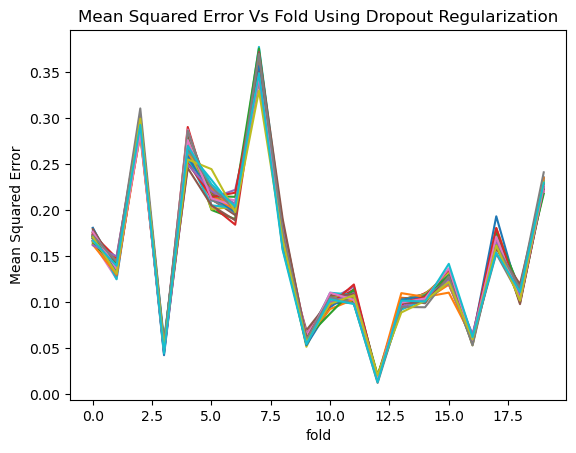

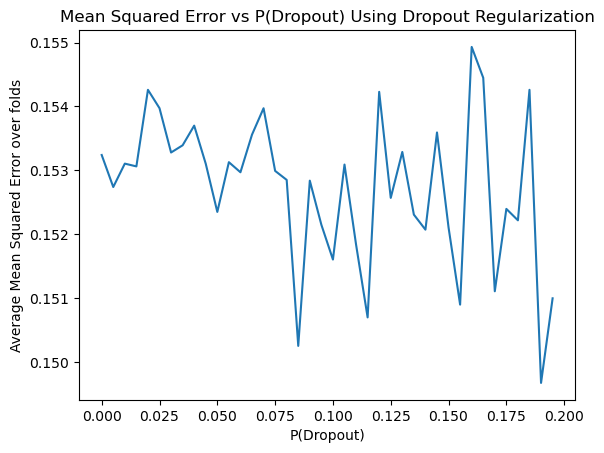

In [79]:
clf = linear_model.LinearRegression()
optimizer = BlackBoxTuner(
    model=clf,
    x=x_scaled,
    y=y,
    regularization_method="Dropout",
    M=20,
    c=[],
    k_folds=20,
    metric="MSE"
)

optimized_model = optimizer.optimize(plot_fold_results=True,plot_metric_vs_tuning_param=True)

Un-optimized Model: MSE: 0.20144241662655887 MAD: 0.37362697516021887
Optimized Model: MSE: 0.03400293768422162 MAD: 0.14771212637004405


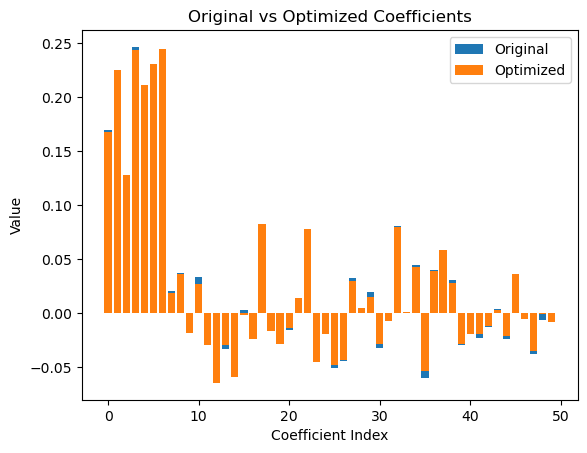

In [80]:
#comparing performance
print("Un-optimized Model: MSE: {} MAD: {}".format(mse_original,mad_original))
print("Optimized Model: MSE: {} MAD: {}".format(optimizer.MSE,optimizer.MAD))
#generate a plot comparing the results

#plot the original model's performance
fig = plt.figure()
coef_nums = np.arange(0,np.shape(model_unoptimized.coef_)[0])
plt.bar(coef_nums,model_unoptimized.coef_, label="Original")
plt.bar(coef_nums,optimized_model.coef_,label="Optimized")
plt.xlabel("Coefficient Index")
plt.ylabel("Value")
plt.title("Original vs Optimized Coefficients")
plt.legend()
plt.show()

As seen from these results, applying dropout regularization did indeed lower the MSE as desired. Additionally, we see that the optimized coefficients are slightly smaller which is what we would expect for this type of regularizatoin (which behaves similar to Ridge with a L2 regularization)

### Tuning using Noise

Regularization method: Noise Addition, Tuning metric: Noise Variance
Best value of Noise Variance: 0.2
MSE: 0.04696628066185556, MAD: 0.1749981702092876


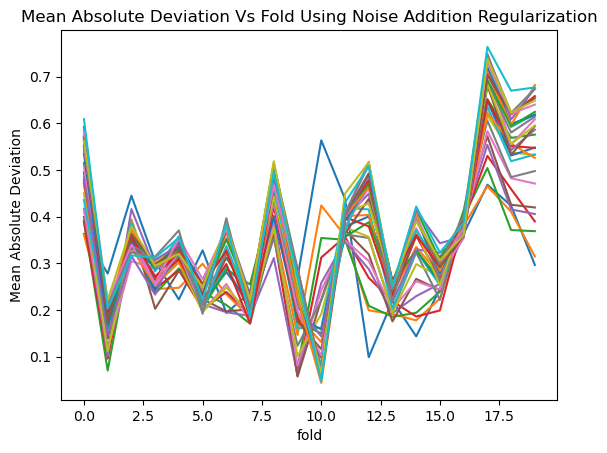

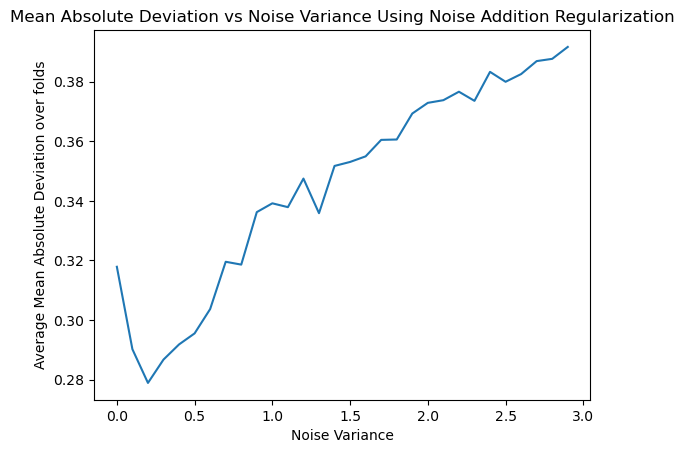

In [81]:
clf = linear_model.LinearRegression()
optimizer = BlackBoxTuner(
    model=clf,
    x=x_scaled,
    y=y,
    regularization_method="NoiseAddition",
    M=20,
    c=[],
    k_folds=20,
    metric="MAD"
)

optimized_model = optimizer.optimize(plot_fold_results=True,plot_metric_vs_tuning_param=True)

Un-optimized Model: MSE: 0.20144241662655887 MAD: 0.37362697516021887
Optimized Model: MSE: 0.04696628066185556 MAD: 0.1749981702092876


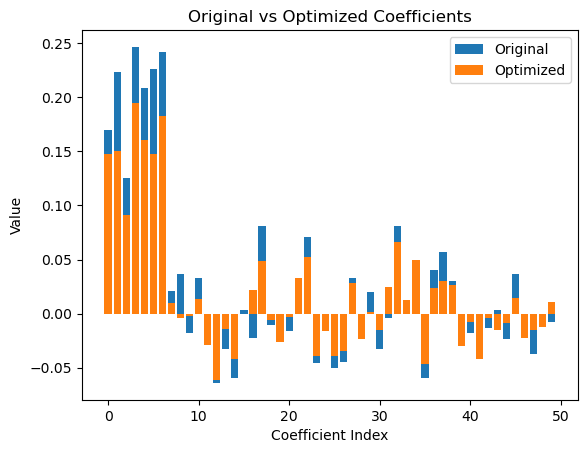

In [82]:
#comparing performance
print("Un-optimized Model: MSE: {} MAD: {}".format(mse_original,mad_original))
print("Optimized Model: MSE: {} MAD: {}".format(optimizer.MSE,optimizer.MAD))
#generate a plot comparing the results

#plot the original model's performance
fig = plt.figure()
coef_nums = np.arange(0,np.shape(model_unoptimized.coef_)[0])
plt.bar(coef_nums,model_unoptimized.coef_, label="Original")
plt.bar(coef_nums,optimized_model.coef_,label="Optimized")
plt.xlabel("Coefficient Index")
plt.ylabel("Value")
plt.title("Original vs Optimized Coefficients")
plt.legend()
plt.show()

Again, in this example, we observed that noise addition regularization reduced the MAD (the desired metric in this case). Additionally, it significantly reduced some of the model coefficients (compared with the original) which is what we would expect for a regularization techniuqe that behaves similar to Lasso (L1 penalty)

## Training using Robust

Regularization method: Robust, Tuning metric: Delta Configuration
Best value of Delta Configuration: 60
MSE: 0.03630097492762488, MAD: 0.1513244735717641


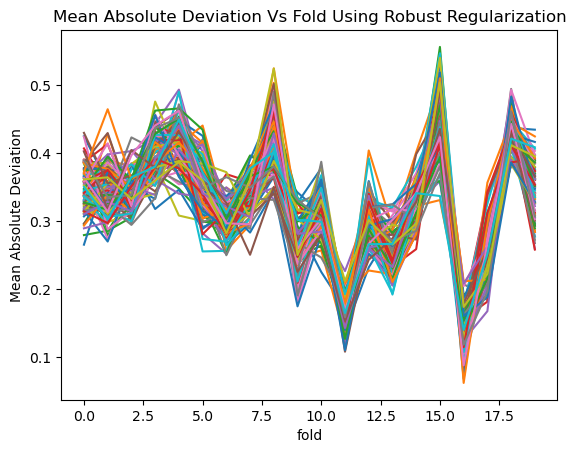

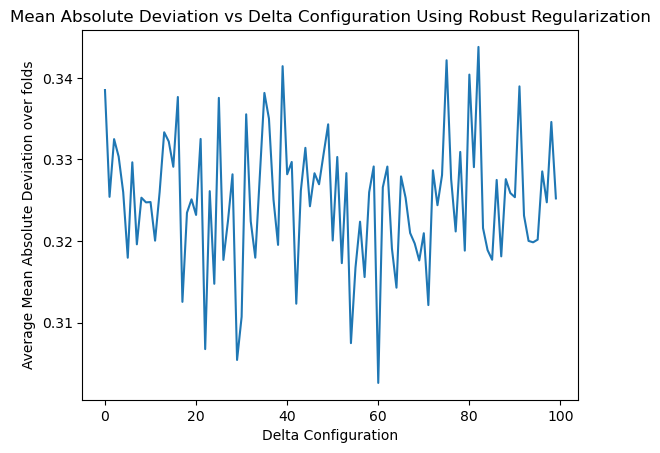

In [83]:
clf = linear_model.LinearRegression()
optimizer = BlackBoxTuner(
    model=clf,
    x=x_scaled,
    y=y,
    regularization_method="Robust",
    c= 0.75 * np.ones((p,1)),
    k_folds=20,
    metric="MAD"
)

optimized_model = optimizer.optimize(plot_fold_results=True,plot_metric_vs_tuning_param=True)

Un-optimized Model: MSE: 0.20144241662655887 MAD: 0.37362697516021887
Optimized Model: MSE: 0.03630097492762488 MAD: 0.1513244735717641


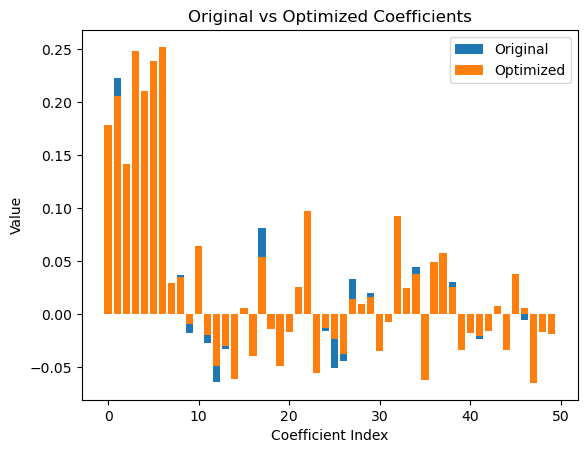

In [84]:
#comparing performance
print("Un-optimized Model: MSE: {} MAD: {}".format(mse_original,mad_original))
print("Optimized Model: MSE: {} MAD: {}".format(optimizer.MSE,optimizer.MAD))
#generate a plot comparing the results

#plot the original model's performance
fig = plt.figure()
coef_nums = np.arange(0,np.shape(model_unoptimized.coef_)[0])
plt.bar(coef_nums,model_unoptimized.coef_, label="Original")
plt.bar(coef_nums,optimized_model.coef_,label="Optimized")
plt.xlabel("Coefficient Index")
plt.ylabel("Value")
plt.title("Original vs Optimized Coefficients")
plt.legend()
plt.show()

In this case, performing robust regularization also lowered the MAD which was the expected bahavior for this type of regularization

# Case Study using decision trees

To ensure that our function performed on "black box" learning models. We performed a case study using the Diabetes dataset. To show that our code works on models that aren't based on linear regression, we decided to use a decision tree regression method. Some of hte code used in this example is taken from the following example (https://scikit-learn.org/stable/modules/tree.html). While the results that we feature below indicate that the code is functioning without error, we did not observe the desired effects consistently Our experiments for all three forms of regularization actually worsened the performance. This is likely the result of poor tuning of the model. Since we used a model (decision tree regression) that we didn't understand to prove that our code worked with black-box models, we were unable to effectively tune the model or the optimization to better work with our desired methods. Still, the results show that our code works and our approach performs reasonably well with black-box models.

## Training the tree and obtaining preliminary results

In [85]:
#load the data set and split into a training set and a test set
diabetes = datasets.load_diabetes()
X,y = diabetes.data, diabetes.target
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=2020)

#fit the decision tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train,y_train)

#evaluate decision tree performance
y_pred = clf.predict(X_test)
mse_original = mean_squared_error(y_test,y_pred)
mad_original = mean_absolute_error(y_test,y_pred)




## Tuning with Dropout

Regularization method: Dropout, Tuning metric: P(Dropout)
Best value of P(Dropout): 0.18


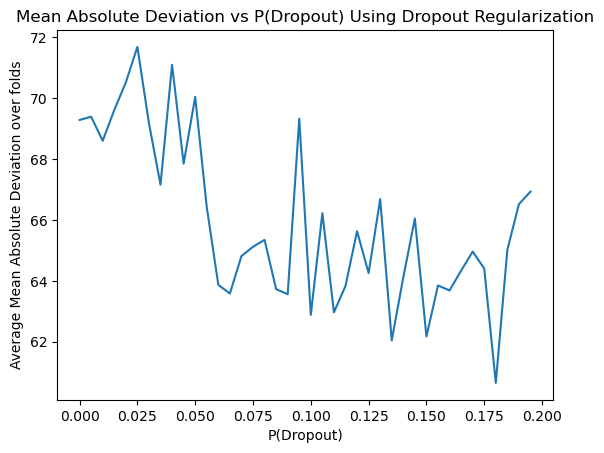

Un-optimized Model: MSE: 5690.540540540541 MAD: 61.4054054054054
Optimized Model: MSE: 5692.55616429599 MAD: 57.47979846992414


In [86]:
clf = tree.DecisionTreeRegressor()
optimizer = BlackBoxTuner(
    model=clf,
    x=X_train,
    y=y_train,
    regularization_method="Dropout",
    M=20,
    c=[],
    k_folds=20,
    metric="MAD"
)

#get optimized model's performance
optimized_model = optimizer.optimize(plot_fold_results=False,plot_metric_vs_tuning_param=True,print_performance=False)
y_pred = optimized_model.predict(X_test)
mse_optimized = mean_squared_error(y_test,y_pred)
mad_optimized = mean_absolute_error(y_test,y_pred)

#print the results
#comparing performance
print("Un-optimized Model: MSE: {} MAD: {}".format(mse_original,mad_original))
print("Optimized Model: MSE: {} MAD: {}".format(mse_optimized,mad_optimized))

## Tuning with Noise Addition

Regularization method: Noise Addition, Tuning metric: Noise Variance
Best value of Noise Variance: 0.0


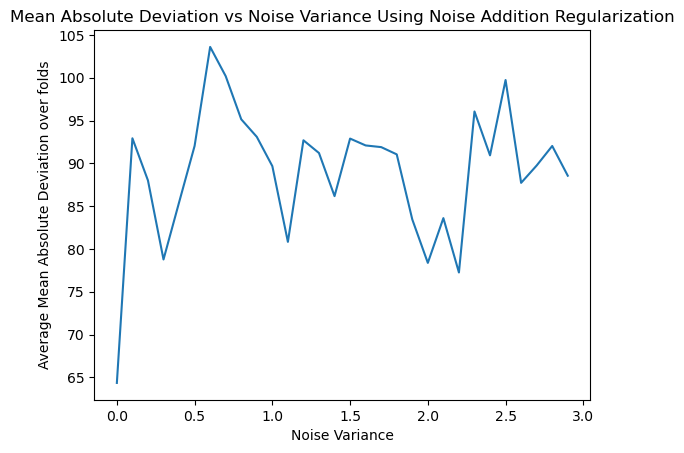

Un-optimized Model: MSE: 5690.540540540541 MAD: 61.4054054054054
Optimized Model: MSE: 5957.621621621622 MAD: 61.81981981981982


In [87]:
clf = tree.DecisionTreeRegressor()
optimizer = BlackBoxTuner(
    model=clf,
    x=X_train,
    y=y_train,
    regularization_method="NoiseAddition",
    M=20,
    c=[],
    k_folds=20,
    metric="MAD"
)

#get optimized model's performance
optimized_model = optimizer.optimize(plot_fold_results=False,plot_metric_vs_tuning_param=True,print_performance=False)
y_pred = optimized_model.predict(X_test)
mse_optimized = mean_squared_error(y_test,y_pred)
mad_optimized = mean_absolute_error(y_test,y_pred)

#print the results
#comparing performance
print("Un-optimized Model: MSE: {} MAD: {}".format(mse_original,mad_original))
print("Optimized Model: MSE: {} MAD: {}".format(mse_optimized,mad_optimized))

## Truning with Robust Regression

Regularization method: Robust, Tuning metric: Delta Configuration
Best value of Delta Configuration: 39


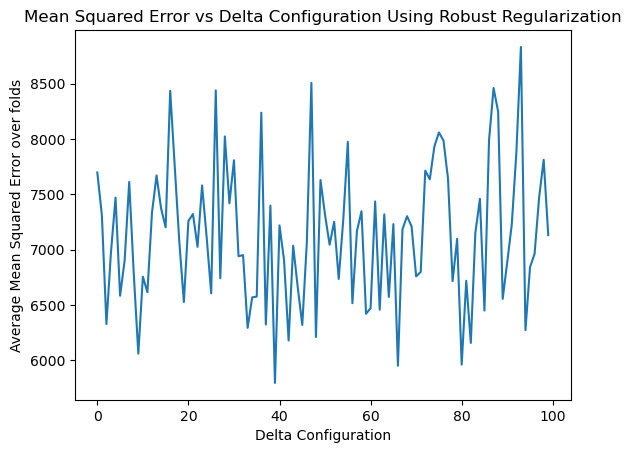

Un-optimized Model: MSE: 5690.540540540541 MAD: 61.4054054054054
Optimized Model: MSE: 5486.72972972973 MAD: 55.54054054054054


In [88]:
clf = tree.DecisionTreeRegressor()
optimizer = BlackBoxTuner(
    model=clf,
    x=X_train,
    y=y_train,
    regularization_method="Robust",
    c= 0.90 * np.ones((p,1)),
    k_folds=20,
    metric="MSE"
)

#get optimized model's performance
optimized_model = optimizer.optimize(plot_fold_results=False,plot_metric_vs_tuning_param=True,print_performance=False)
y_pred = optimized_model.predict(X_test)
mse_optimized = mean_squared_error(y_test,y_pred)
mad_optimized = mean_absolute_error(y_test,y_pred)

#print the results
#comparing performance
print("Un-optimized Model: MSE: {} MAD: {}".format(mse_original,mad_original))
print("Optimized Model: MSE: {} MAD: {}".format(mse_optimized,mad_optimized))